# 17  基于MindSpore构造Dropout层

本实验主要介绍使用MindSpore深度学习框架构造Dropout层。

# 1 实验目的
- 掌握如何使用Mindspore深度学习框架构造Dropout层；
- 了解Dropout层的相关原理以及应用；
- 了解如何在一维度线性模型中使用dropout层。

# 2 dropout层背景及知识点介绍
## 2.1背景知识
2012年，Hinton在论文[《Improving neural networks by preventing co-adaptation of feature detectors》](https://arxiv.org/pdf/1207.0580.pdf)中提出Dropout。当一个复杂的前馈神经网络被训练在小数据集时，容易造成过拟合。为了防止过拟合，可以通过阻止特征检测器的共同作用来提高神经网络的性能。同年，Alex、Hinton在论文[《ImageNet Classification with Deep Convolutional Neural Networks》](https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=1166C42C86BD3A3C6C75B53E2CD2E14F?doi=10.1.1.299.205&rep=rep1&type=pdf)中使用了Dropout算法，用于防止过拟合。该论文赢得了2012年图像识别大赛冠军。随后，关于Dropout的论文[《Dropout:A Simple Way to Prevent Neural Networks from Overfitting》](http://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)、[《Improving Neural Networks with Dropout》](http://www.cs.toronto.edu/~nitish/msc_thesis.pdf)、[《Dropout as data augmentation》](https://arxiv.org/pdf/1506.08700.pdf)等不断提高Dropout层的应用。

## 2.2Dropout原理介绍

Dropout作为训练深度神经网络的trick供开发者选择。其原理是在每个训练批次中，通过忽略一半的特征检测器（让一半的隐层节点值为0），从而地减少过拟合现象。这种方式可以减少特征检测器（隐层节点）间的相互作用（检测器相互作用是指某些检测器依赖其他检测器才能发挥作用）。具体的说：在前向传播时，让某个神经元的激活值以一定的概率p停止工作，从而使模型泛化性更强，减少对某些局部的特征的依赖。

![avatar](fig/fig1.png)


# 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=MindSpore 2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|MindSpore官网华为开源自研AI框架MindSpore。自动微分、并行加持，一次训练，可多场景部署。支持端边云全场景的深度学习训练推理框架，主要应用于计算机视觉、自然语言处理等AI领域，面向数据科学家、算法工程师等人https://www.mindspore.cn/install

# 4 数据处理
## 4.1 数据准备
调用numpy接口随机生成自变量 $x$, 根据自定义函数加入随机噪声后生成因变量 $y$, 数据形式如下所示：  
$$
[<x_1, y_1>, <x_2,y_2>, \dots ,<x_n,y_n>] 
$$

## 4.2 数据加载
使用自定义函数生成实验数据。这里需要拟合的回归模型是 $y = 2x+3$, 为了达到学习效果，人为增加一些噪声进行干扰，部分实验数据如下所示，每个数组数据代表一个数据点的坐标。  

In [1]:
import numpy as np
from mindspore import dataset as ds
# 自定义数据生成函数
def get_data(num,w=2,b=3):
    for data in range(num):
        # 在一定范围内随机生成自变量
        x=np.random.uniform(-10,10)
        # 生成随机噪声
        noise=np.random.normal(0,1)
        # 加入噪声之后得到因变量
        y=x*w+b+noise
        # 返回数据
        yield np.array([x]).astype(np.float32),np.array([y]).astype(np.float32)

# 展示部分数据
eval_data=list(get_data(6))
x_eval_label,y_eval_label=zip(*eval_data)
eval_data

# 数据集生成函数
def create_dataset(num_data,batch_size=16,repeat_size=1):
    input_data=ds.GeneratorDataset(list(get_data(num_data)),column_names=['data','label'])
    # 设置数据批次
    input_data=input_data.batch(batch_size) 
    # 设置数据重复次数
    input_data=input_data.repeat(repeat_size) 
    return input_data

data_number=1600         # 数据数量
batch_number=16          # 数据批次
repeat_number=1          # 数据重复次数
# 生成数据集
ds_train=create_dataset(data_number,batch_number,repeat_number)
# 打印数据集批次
print('数据集批次：',ds_train.get_dataset_size())
# 创建数据集字典
dict_datasets=next(ds_train.create_dict_iterator())
# 打印数据集信息
print(dict_datasets.keys())
print('X:',dict_datasets['data'].shape)
print('y:',dict_datasets['label'].shape)

数据集批次： 100
dict_keys(['data', 'label'])
X: (16, 1)
y: (16, 1)


# 5 模型构建
## 5.1 导入python库
在使用前，导入需要的Python库。
详细的MindSpore的模块说明，可以在MindSpore API页面中搜索查询。
可以通过context.set_context来配置运行需要的信息，譬如运行模式、后端信息、硬件等信息。

In [2]:
# 引入time模块
import time
# 引入numpy科学计算库
import numpy as np
# 引入绘图库
import matplotlib.pyplot as plt
# 引入MindSpore库
import mindspore 
# 神经网络模块
import mindspore.nn as nn
# 常见算子模块
import mindspore.ops as ops
# 张量,参数和参数元组
from mindspore import Tensor, ParameterTuple, Parameter 
# 数据类型
from mindspore import dtype as mstype
# 数据集
from mindspore import dataset as ds
# 引入Normal接口
from mindspore.common.initializer import Normal
# 引入Model模块
from mindspore.train import Model
# 引入LossMonitor模块
from mindspore.train import LossMonitor
# display模块
from IPython import display
# 引入回调函数
from mindspore.train import Callback
# 设置随机数生成种子 
np.random.seed(123)

## 5.2 构建一维线性回归模型
定义一个线性层并初始化权重和偏置，在构置的consruct函数中加载dropout层，并设置放弃率。

In [3]:
# 定义一个简单的一维线性回归模型
class LinearNet(nn.Cell):
    # 定义线性层
    def __init__(self):
        super(LinearNet,self).__init__()
        # 使用全连接层表示一维线性回归模型，初始化权重和偏置
        self.fc=nn.Dense(1,1,Normal(0.02),Normal(0.02),has_bias=True) 
    # 构造函数
    def construct(self,x):
         # 构造Dropout层，放弃率设置为0.7
        net2 = nn.Dropout(keep_prob=0.7)
        # 将输入数据通过Dropout层
        x=net2(x)
        x=self.fc(x)
        return x

## 5.3 定义损失函数、优化器
实例化一维线性回归模型，并使用mindspore相关函数定义损失函数以及优化器。

In [4]:
# 一维线性回归模型实例化
net=LinearNet()
# 定义损失函数
net_loss=nn.loss.MSELoss()
# 传入模型的训练参数，以及学习率等参数
opt=nn.Momentum(net.trainable_params(),learning_rate=0.005,momentum=0.9)
# 定义模型
model=Model(net,net_loss,opt)
# 打印模型中的参数维度形状信息
model_params=net.trainable_params()
for param in model_params:
    print(param,param.asnumpy())

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.02515898]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [-0.01981865]


# 6.模型训练
## 6.1 可视化
使用函数画出模型拟合之直线以及真实的数据拟合直线的对比。

In [5]:
# 定义函数画出模型拟合之直线以及真实的数据拟合直线的对比
def plot_model_and_datasets(net, eval_data):
    # 权重
    weight = net.trainable_params()[0]
    # 偏置
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3
    # 绘制图像
    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()
# 定义回调函数，训练过程中画出模型拟合的曲线
class ImageShowCallback(Callback):
    # 初始化
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data
    # 绘制图像
    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        # 清除打印内容，实现动态拟合效果
        display.clear_output(wait=True)

## 6.2 训练
绘制训练过程中的拟合直线图，并打印损失函数。

In [6]:
# 训练回合数
epoch = 1
# 绘制训练过程中拟合直线图像
imageshow_cb = ImageShowCallback(net, eval_data)
# 开始训练
#打印损失函数
loss_monitor = LossMonitor(10)
model.train(epoch, ds_train, callbacks=[loss_monitor], dataset_sink_mode=False)

epoch: 1 step: 100, loss is 0.5019777417182922


# 7. 模型预测
将数据传入线性回归模型，并打印出预测结果与真实数据对比图。

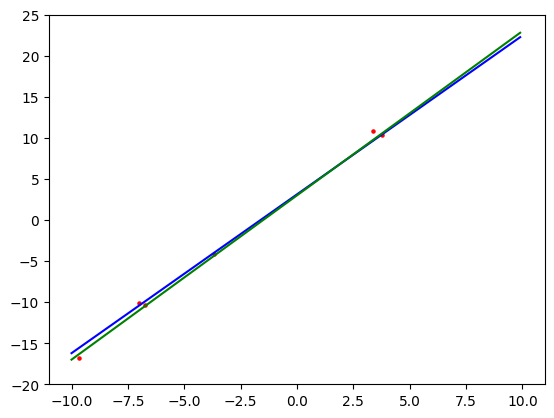

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[1.9335083]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [3.1219738]


In [7]:
# 传入线性回归模型和数据
plot_model_and_datasets(net, eval_data)
# 打印模型参数和训练结果
for net_param in net.trainable_params():
    print(net_param, net_param.asnumpy())